In [32]:
# KNN -->> we can use it both classification and regression --->> but here we are using KNN in classification.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

warnings.filterwarnings('ignore')

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, precision_recall_curve
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV

from collections import Counter


In [33]:
data = pd.read_csv('loan_prediction.csv')
data.head(3)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y


In [34]:
data['Loan_Status'].value_counts()

Loan_Status
Y    422
N    192
Name: count, dtype: int64

In [35]:
data.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [36]:
data['Dependents'].unique() ## occur 3+

array(['0', '1', '2', '3+', nan], dtype=object)

In [37]:
 data['Dependents'] = data['Dependents'].replace('3+', 3) # Inplace = True, we are not using because we store it same dataset.

In [38]:
data['Dependents'] = data['Dependents'].astype('float')

In [39]:
data['Dependents'].unique()

array([ 0.,  1.,  2.,  3., nan])

In [40]:
data_num = data.select_dtypes(exclude = 'object')
data_num.head(3)

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,0.0,5849,0.0,NaN,360.0,1.0
1,1.0,4583,1508.0,128.0,360.0,1.0
2,0.0,3000,0.0,66.0,360.0,1.0


In [41]:
data_cat = data.select_dtypes(include = 'object')
data_cat.head(3)

,Loan_ID,Gender,Married,Education,Self_Employed,Property_Area,Loan_Status
0,LP001002,Male,No,Graduate,No,Urban,Y
1,LP001003,Male,Yes,Graduate,No,Rural,N
2,LP001005,Male,Yes,Graduate,Yes,Urban,Y


In [42]:
# We can drop unique values or ids because we can't train with unique values or ids.

In [43]:
data.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [44]:
# filling null or missing values with new method(skewness) ----->>>> range of skewness(-0.5 to 0.5)

# First we are finding skewness.
sk = []
def skewness(num):
    for i in num:
        a = (num[i].mean() - num[i].mode()[0]) / (num[i].std())
        sk.append(a)
    return sk

In [45]:
b = skewness(data_num)
b

[0.7515030872196665,
 0.47527246311577237,
 0.5540356092387764,
 0.30859899043957384,
 -0.2764110367269907,
 -0.4324768289054649]

In [46]:
# filling 

for i in data_num:
    for j in range(len(b)):
        if -0.5 <= b[j] <= 0.5:
            data_num[i].fillna(data_num[i].mean(), inplace = True)
        else:
            data_num[i].fillna(data_num[i].median(), inplace = True)

data_num.isnull().sum()

Dependents           0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
dtype: int64

In [47]:
data_ob = data.select_dtypes(include = 'object')
data_ob

,Loan_ID,Gender,Married,Education,Self_Employed,Property_Area,Loan_Status
0,LP001002,Male,No,Graduate,No,Urban,Y
1,LP001003,Male,Yes,Graduate,No,Rural,N
2,LP001005,Male,Yes,Graduate,Yes,Urban,Y
3,LP001006,Male,Yes,Not Graduate,No,Urban,Y
4,LP001008,Male,No,Graduate,No,Urban,Y
...,...,...,...,...,...,...,...
609,LP002978,Female,No,Graduate,No,Rural,Y
610,LP002979,Male,Yes,Graduate,No,Rural,Y
611,LP002983,Male,Yes,Graduate,No,Urban,Y
612,LP002984,Male,Yes,Graduate,No,Urban,Y


In [48]:
data_ob.isnull().sum()

Loan_ID           0
Gender           13
Married           3
Education         0
Self_Employed    32
Property_Area     0
Loan_Status       0
dtype: int64

In [49]:
data_ob['Gender'].fillna('unknown', inplace = True)

data_ob['Self_Employed'].fillna(data_ob['Self_Employed'].mode()[0], inplace = True)
data_ob['Married'].fillna(data_ob['Married'].mode()[0], inplace = True)

In [50]:
data_ob = data_ob.drop(['Loan_ID'], axis = 1)

In [51]:
data1 = pd.concat([data_num, data_ob], axis = 1)

In [52]:
data1.head(3)

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender,Married,Education,Self_Employed,Property_Area,Loan_Status
0,0.0,5849,0.0,128.0,360.0,1.0,Male,No,Graduate,No,Urban,Y
1,1.0,4583,1508.0,128.0,360.0,1.0,Male,Yes,Graduate,No,Rural,N
2,0.0,3000,0.0,66.0,360.0,1.0,Male,Yes,Graduate,Yes,Urban,Y


In [53]:
# LabelEncoder
# Zscore
# split

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for i in data_ob:
    data1[i] = le.fit_transform(data1[i])

In [54]:
data1.head(3)

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender,Married,Education,Self_Employed,Property_Area,Loan_Status
0,0.0,5849,0.0,128.0,360.0,1.0,1,0,0,0,2,1
1,1.0,4583,1508.0,128.0,360.0,1.0,1,1,0,0,0,0
2,0.0,3000,0.0,66.0,360.0,1.0,1,1,0,1,2,1


In [55]:
data1.shape

(614, 12)

In [58]:
from scipy.stats import zscore
z = np.abs(zscore(data1))
data2 = data1[(z<3).all(axis = 1)]
print('Before ZScore', data1.shape)
print('After ZScore', data2.shape)
data1 = data2.copy()

Before ZScore (614, 12)
After ZScore (577, 12)


In [59]:
X = data1.drop('Loan_Status', axis = 1)
y = data1['Loan_Status']

In [60]:
scaler = StandardScaler()
X_sc = scaler.fit_transform(X)
X_sc

array([[-0.72331271,  0.39926641, -0.86103617, ..., -0.54196123,
        -0.38058018,  1.22747207],
       [ 0.2823534 , -0.02802029,  0.05284031, ..., -0.54196123,
        -0.38058018, -1.30652215],
       [-0.72331271, -0.56229742, -0.86103617, ..., -0.54196123,
         2.62756724,  1.22747207],
       ...,
       [ 0.2823534 ,  1.14954946, -0.71559164, ..., -0.54196123,
        -0.38058018,  1.22747207],
       [ 1.28801951,  0.98450744, -0.86103617, ..., -0.54196123,
        -0.38058018,  1.22747207],
       [-0.72331271, -0.02802029, -0.86103617, ..., -0.54196123,
         2.62756724, -0.03952504]])

In [ ]:
# topic isi Multicollinearity learn on Monday(29/12/2025)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X_sc, y, test_size = 0.25, random_state = 0)

In [67]:
# Let's fit the daat into KNN model and see how well it performs:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [68]:
knn.score(X_train, y_train)

0.8402777777777778

In [69]:
y_pred = knn.predict(X_test)

In [70]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.46      0.59        48
           1       0.78      0.95      0.86        97

    accuracy                           0.79       145
   macro avg       0.80      0.70      0.72       145
weighted avg       0.79      0.79      0.77       145



In [71]:
print(confusion_matrix(y_test, y_pred))

[[22 26]
 [ 5 92]]


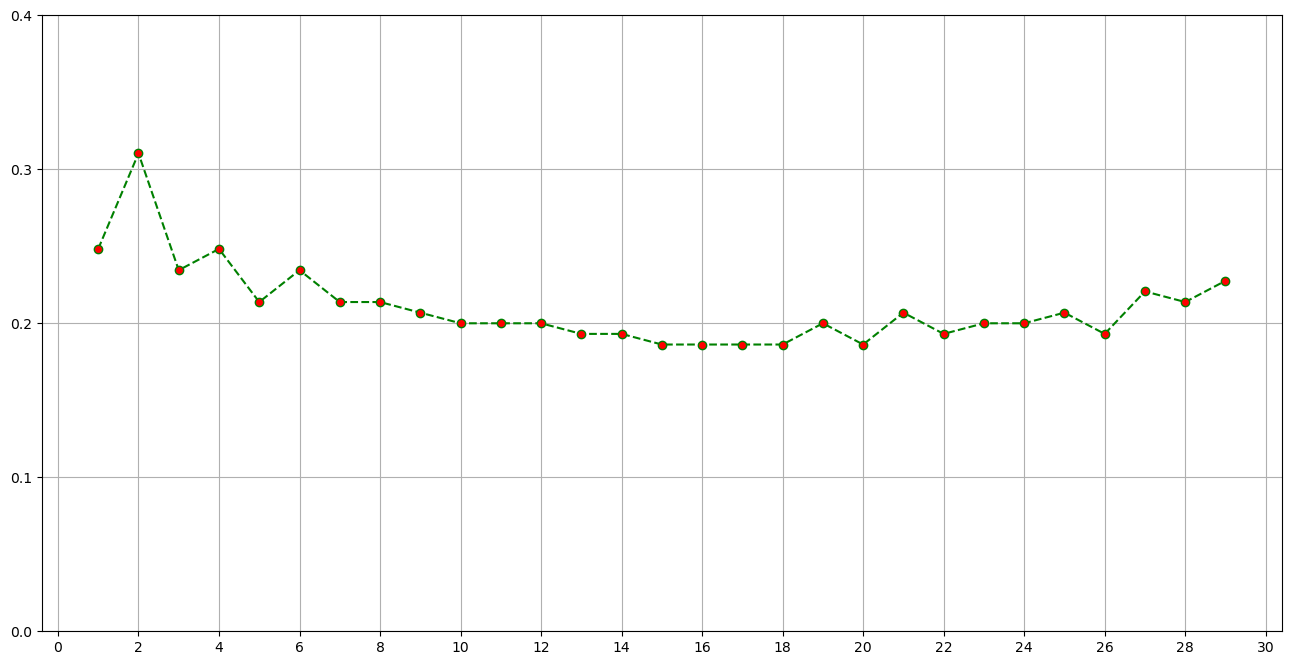

In [94]:
# Alternative method to find the optimal value of "K".

error_rate = []
for i in range(1,30):
    Knc = KNeighborsClassifier(n_neighbors = i)
    Knc.fit(X_train, y_train)
    y_pred_i = Knc.predict(X_test)
    error_rate.append(np.mean(y_pred_i != y_test))
    
plt.figure(figsize=(16,8)) # canvas size.
plt.plot(range(1,30), error_rate, linestyle = 'dashed', color = 'green', marker = 'o', markerfacecolor = 'red')
plt.xticks(np.arange(0,32,2))
plt.yticks(np.arange(0,.5,0.1))
plt.grid() # Grid lines on.
plt.show()

In [91]:
# we will use the best parameters in out K-NN algo and check if accuracy is increasing 
knn = KNeighborsClassifier(n_neighbors = 20)

In [92]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=20)

In [93]:
knn.score(X_train, y_train)

0.8078703703703703